# Capstone project using Google Home Solar panel information from Kaggle

https://www.kaggle.com/jboysen/google-project-sunroof

Google's "Project Sunroof" has compiled a data set which computes how much sunlight hits all rooftops in a year. It takes into account:

* Google's database of imagery and maps
* 3D modeling of the roofs
* Shadows cast by nearby structures and trees
* All possible sun positions over the course of a year
* Historical cloud and temperature patterns that might affect solar energy production

This particular subset is reported for each US state. It contains the following information:

* State longitude and latitude details
* Summarized total available roof-space broken down by compass direction
* Calculates total usable sunlight and estimated "carbon offset" potential
* Current count of buildings with solar panels installed

We would like to ask the general question: <b> What factors contribute to the current count of each state's solar panel installation? </b> Using the information provided by this data set in addition with other state attributes, we will construct a basic formula to predict total solar panel installations for each state.

* Part I: Use the data included in the Solar panel data set. How predictive is a state's relative location (longitude and latitude) and overall state "sunshine" factor to predict total solar panel installations?
* Part II: Bring in additional state data to determine how population, GDP and political party leaning can predict solar panel installations.
* Part III: Using correlation calculations as a guide, develop a single formula to predict solar panel installations for each state.


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Initial analysis
This is our baseline table, Project Sunroof data set for current solar panel installation, by state. 

In [94]:

solar = pd.read_csv('Files/solarstate.csv')
pd.set_option('precision', 2)
solar.head(5)

,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
0,NaN,NaN,32.65,32.54,-115.67,-117.03,32.57,-116.63,1300.36,2,...,4.75e+03,7.69e+03,0.00e+00,0.00e+00,0.00e+00,5209.46,1.24e+04,"[[0,2]]",0.00e+00,0
1,Alabama,Alabama,34.99,30.19,-84.96,-88.41,32.94,-86.85,1083.96,700683,...,1.13e+09,3.87e+09,2.42e+09,2.80e+09,8.74e+09,12069.32,1.90e+10,"[[0,137667],[5,221548],[10,148580],[15,74864],...",1.20e+07,549
2,Alaska,Alaska,71.34,51.85,-131.52,-176.66,61.37,-148.51,799.53,27583,...,2.19e+06,1.12e+08,4.49e+07,4.49e+07,2.63e+08,6540.61,4.66e+08,"[[0,7503],[5,10425],[10,4409],[15,1538],[20,84...",1.92e+05,83
3,Arizona,Arizona,37.00,31.33,-109.05,-114.79,33.35,-111.89,1378.22,1638999,...,1.78e+09,1.09e+10,6.05e+09,8.64e+09,1.91e+10,18974.80,4.64e+10,"[[0,199346],[5,449953],[10,417070],[15,259587]...",1.99e+07,39553
4,Arkansas,Arkansas,36.50,33.01,-89.73,-94.62,35.10,-92.65,1074.69,322235,...,4.55e+08,1.80e+09,1.02e+09,1.31e+09,4.36e+09,12099.95,8.94e+09,"[[0,62028],[5,98712],[10,69090],[15,34138],[20...",5.62e+06,238


Create a new data frame with the subset of desired factors: longitiude, latitude, average yearly sunlight potential, and solar planel installation count. Columns are renamed for additional clarity. Unsorted data (index zero, NaN with zero installs is removed.)

In [95]:
summary = solar[['state_name', 'lat_avg', 'lng_avg',  'yearly_sunlight_kwh_kw_threshold_avg', 'existing_installs_count']]
summary = summary.drop(summary.index[0])


In [96]:
# Clean up column titles, sort by installs

summary.rename(columns={'existing_installs_count': 'Installs', 'yearly_sunlight_kwh_kw_threshold_avg': 'Sunshine', 
    'state_name': 'State'}, inplace=True)
table = summary.sort_values('Installs', ascending=False)
table.head(10)

,State,lat_avg,lng_avg,Sunshine,Installs
5,California,35.58,-119.43,1276.81,328899
10,Florida,27.91,-81.75,1162.08,104123
3,Arizona,33.35,-111.89,1378.22,39553
12,Hawaii,21.14,-157.51,1272.31,25414
6,Colorado,39.53,-105.22,1246.37,24140
33,New York,41.79,-74.91,983.90,19979
22,Massachusetts,42.22,-71.30,979.22,15331
44,Texas,30.89,-97.38,1129.56,13969
29,Nevada,37.07,-116.32,1374.39,12759
31,New Jersey,40.37,-74.47,1002.43,12640


In [97]:
table.tail(10)

,State,lat_avg,lng_avg,Sunshine,Installs
16,Iowa,41.94,-93.22,1019.50,248
4,Arkansas,35.10,-92.65,1074.69,238
28,Nebraska,41.16,-97.21,1076.77,208
46,Vermont,44.06,-72.85,950.30,131
8,Delaware,39.36,-75.53,1037.24,90
2,Alaska,61.37,-148.51,799.53,83
49,West Virginia,38.81,-80.84,978.62,80
51,Wyoming,42.61,-106.88,1181.33,29
35,North Dakota,47.32,-99.47,979.55,24
42,South Dakota,43.98,-98.98,1077.56,21


First inspection of the data shows what we might expect, large sunny states have the highest total installations, while northern small states have few. Note that California has over 300,000 installs, while some states show fewer than 100. This will result in large ranges that might be difficult to visualize in graphs, as can be seen when we make bar charts and box plots of the different factors.

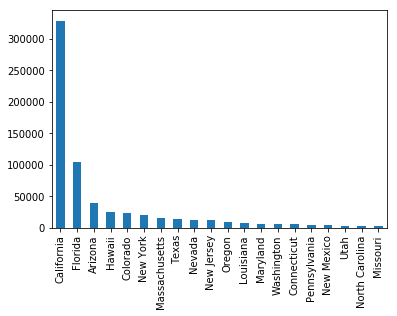

In [98]:
ax = table.Installs.head(20).plot(kind='bar')
ax.set_xticklabels(table.State, rotation=90)
ax

lat_avg        Axes(0.125,0.536818;0.352273x0.343182)
lng_avg     Axes(0.547727,0.536818;0.352273x0.343182)
Sunshine          Axes(0.125,0.125;0.352273x0.343182)
Installs       Axes(0.547727,0.125;0.352273x0.343182)
dtype: object

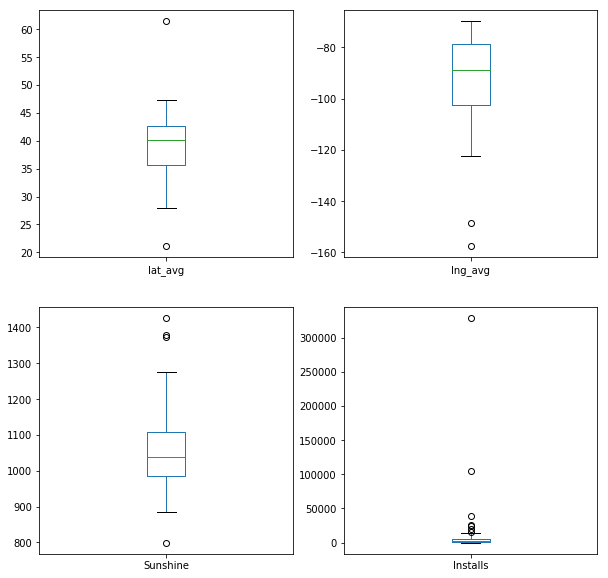

In [99]:
table.plot(subplots='True', kind='box', layout=(2,2), figsize=(10,10))

Note Alaska and Hawaii are outliers for both latitude and longitude.

Looking back at the original table, we saw that populous states had the most installs. Let's bring in state population and look at installs per capita, which should result in a narrower range, and bring in the number of data point outliers.

In [100]:
pop = pd.read_csv("Files/StatePop.csv", usecols=[1,2])  # State population in 2016
table = pd.merge(pop, table, on='State')
table['InstallPerCap'] = 10000 * table['Installs'] / table['Population']
table = table.sort_values('InstallPerCap', ascending=False)
table.head(5)

,State,Population,lat_avg,lng_avg,Sunshine,Installs,InstallPerCap
39,Hawaii,1360301,21.14,-157.51,1272.31,25414,186.83
0,California,37253956,35.58,-119.43,1276.81,328899,88.29
15,Arizona,6392017,33.35,-111.89,1378.22,39553,61.88
3,Florida,18801310,27.91,-81.75,1162.08,104123,55.38
21,Colorado,5029196,39.53,-105.22,1246.37,24140,48.00


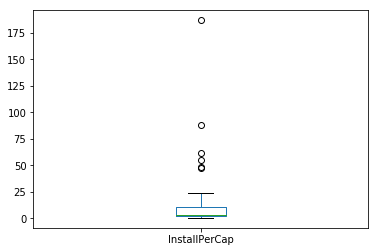

In [101]:
table.InstallPerCap.plot(kind='box')

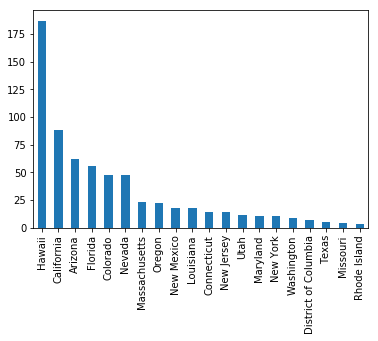

In [102]:
ax = table.InstallPerCap.head(20).plot(kind='bar')
ax.set_xticklabels(table.State, rotation=90)
ax

This looks more manageable. Now we can test whether longitude, latitude, and sunshine correlate to the installations. We'll create a correlations table and inspect the scatter plots.

In [103]:
table.corr()

,Population,lat_avg,lng_avg,Sunshine,Installs,InstallPerCap
Population,1.00,-0.28,0.05,0.13,0.73,0.23
lat_avg,-0.28,1.00,-0.05,-0.63,-0.22,-0.51
lng_avg,0.05,-0.05,1.00,-0.33,-0.21,-0.55
Sunshine,0.13,-0.63,-0.33,1.00,0.33,0.53
Installs,0.73,-0.22,-0.21,0.33,1.00,0.49
InstallPerCap,0.23,-0.51,-0.55,0.53,0.49,1.00


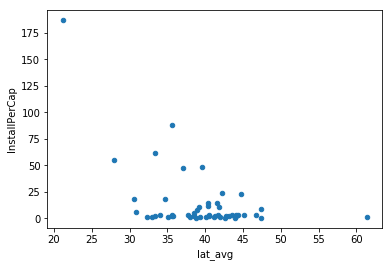

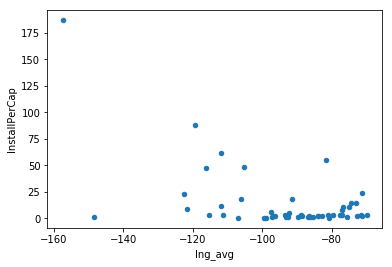

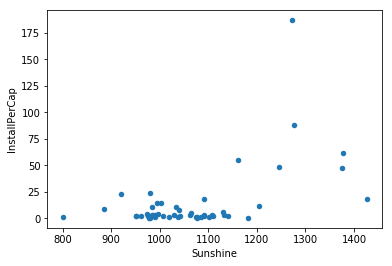

In [104]:
for i in ['lat_avg', 'lng_avg', 'Sunshine']:
    table.plot(x=i, y='InstallPerCap', kind='scatter')

The first thing we see in all three graphs is that there is a large percentage of states which have very few installs, spread out through the tested factors. However, all three factors to indicate some trends:
* States with lower latitudes have higher install rates.
* Western states have higher install rates than eastern ones (although there might be an uptick at the east coast?)
* States with higher sunshine indexes have more installs.

The sunshine factor is not independent of either latitude or longitude, so we might be measuring the same thing to some degree.

## Testing additional factors
Inspection of the table suggests other possible correlations which might be interesting to check, including state wealth, population density, and political leaning.
<br>
We'll bring in some other data we think might be relavant to correlations of installations.
The following data sets were taken from state ranking data found on Wikipedia. Formatting was done 
manually through Vim editing of the csv files.

In [105]:
size = pd.read_csv("Files/StateLandSize.csv", usecols=[1,2]) # State size in square miles
money = pd.read_csv("Files/StatesGDP.csv", usecols=[1,2])  # State GDP in 2016
poli = pd.read_csv("Files/StatesPoli.csv") # State Democrat/Republican ranking based on 2016 election results
rain = pd.read_csv("Files/StateRain.csv")  # Average state rainfall

Individual new frames will be merged into the main table using "State" as the matching key. Then we'll review each new factor in scatter plots, as before.



In [106]:
table = pd.merge(size, table, on='State')
table = pd.merge(rain, table, on='State')
table = pd.merge(money, table, on='State')
table = pd.merge(poli, table, on='State')
table.head(5)

# Ranmame columns and resort by installs

table = table.rename(columns={'2016' : 'GDP', 'square_miles' : 'Size'})
table = table.sort_values('InstallPerCap', ascending=False)
table.head(5)

,State,BlueRank,GDP,Rain,Size,Population,lat_avg,lng_avg,Sunshine,Installs,InstallPerCap
5,Hawaii,49.8,83917,63.7,6422.62,1360301,21.14,-157.51,1272.31,25414,186.83
6,California,50.3,2602672,22.2,155959.34,37253956,35.58,-119.43,1276.81,328899,88.29
22,Arizona,41.4,302952,13.6,113634.57,6392017,33.35,-111.89,1378.22,39553,61.88
20,Florida,42.5,926817,54.5,53926.82,18801310,27.91,-81.75,1162.08,104123,55.38
23,Colorado,42.4,323692,15.9,103717.53,5029196,39.53,-105.22,1246.37,24140,48.00


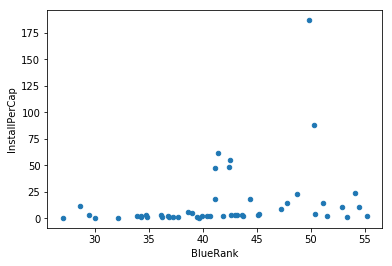

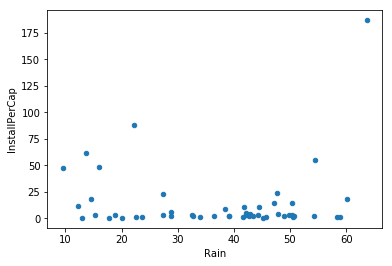

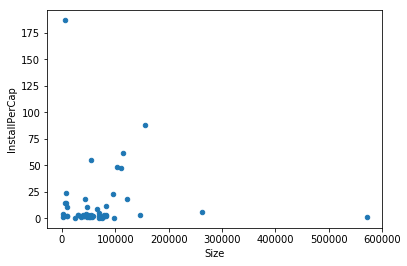

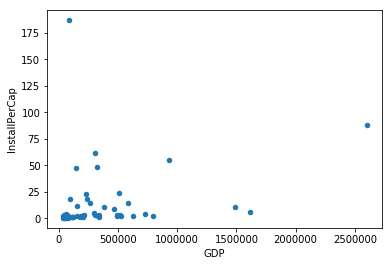

In [107]:
for i in ['BlueRank', 'Rain', 'Size', 'GDP']:
    table.plot(x=i, y='InstallPerCap', kind='scatter')

It's not clear from inspection that rain or absolute state size correclate well. Political leaning (BlueRank) seems to show a stonger correlation, as does GDP with the obvious outlier of Hawaii. We'll adjust GDP to per-capita GDP and see how that looks.




In [108]:
table["GDPperCapita"] = 10000 * table.GDP / table.Population
table.head(5)

,State,BlueRank,GDP,Rain,Size,Population,lat_avg,lng_avg,Sunshine,Installs,InstallPerCap,GDPperCapita
5,Hawaii,49.8,83917,63.7,6422.62,1360301,21.14,-157.51,1272.31,25414,186.83,616.90
6,California,50.3,2602672,22.2,155959.34,37253956,35.58,-119.43,1276.81,328899,88.29,698.63
22,Arizona,41.4,302952,13.6,113634.57,6392017,33.35,-111.89,1378.22,39553,61.88,473.95
20,Florida,42.5,926817,54.5,53926.82,18801310,27.91,-81.75,1162.08,104123,55.38,492.95
23,Colorado,42.4,323692,15.9,103717.53,5029196,39.53,-105.22,1246.37,24140,48.00,643.63


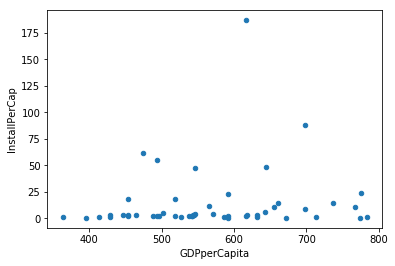

In [109]:
table.plot(x='GDPperCapita', y='InstallPerCap', kind='scatter')


## Building a function incorporating all factors
Inspecting all graphs, we see that some factors show little or no correlations (state size, rain)
while others all show positive correlations (best-fit squares lines slope up-right.)
<br>
<br>
We can combine the factors which show correlation and ideally generate a single plot with few outliers.
* Installs = f(Sunshine, latitude, longitude, GDP, Population, BlueRank)

We'll generate a new column of these calculated factors, and play with the coefficients and normalizations:

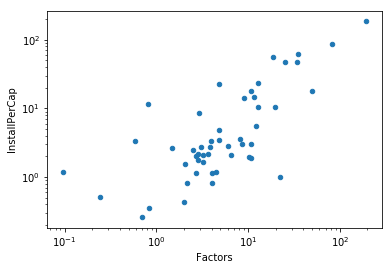

In [110]:
# table['Factors'] = (np.log(table['Population']) * (table['GDP']) * (table['BlueRank'] - 26)**2 
#                    * ((table['Sunshine'] - 795)**2)) / 10**13
table['Factors'] = ((table['GDP']) * (table['BlueRank'] - 25)**2 * -(table['lng_avg'] - 50)
                    * ((table['Sunshine'] - 750)**2) / ( (table['lat_avg'] - 10) * table['Population'] * 10**6))
table.plot(x='Factors', y='InstallPerCap', kind='scatter', loglog=True)

In [111]:
table.corr()

,BlueRank,GDP,Rain,Size,Population,lat_avg,lng_avg,Sunshine,Installs,InstallPerCap,GDPperCapita,Factors
BlueRank,1.00,0.34,0.36,-0.27,0.29,-0.05,0.27,-0.18,0.22,0.28,0.39,0.33
GDP,0.34,1.00,0.01,0.14,0.99,-0.21,0.04,0.11,0.75,0.24,0.32,0.20
Rain,0.36,0.01,1.00,-0.47,0.06,-0.45,0.47,-0.32,-0.11,0.05,-0.17,0.11
Size,-0.27,0.14,-0.47,1.00,0.13,0.40,-0.60,-0.02,0.13,-0.02,0.15,-0.04
Population,0.29,0.99,0.06,0.13,1.00,-0.28,0.07,0.12,0.74,0.23,0.22,0.18
lat_avg,-0.05,-0.21,-0.45,0.40,-0.28,1.00,-0.05,-0.63,-0.22,-0.51,0.34,-0.53
lng_avg,0.27,0.04,0.47,-0.60,0.07,-0.05,1.00,-0.33,-0.21,-0.55,-0.08,-0.51
Sunshine,-0.18,0.11,-0.32,-0.02,0.12,-0.63,-0.33,1.00,0.33,0.53,-0.22,0.51
Installs,0.22,0.75,-0.11,0.13,0.74,-0.22,-0.21,0.33,1.00,0.49,0.17,0.41
InstallPerCap,0.28,0.24,0.05,-0.02,0.23,-0.51,-0.55,0.53,0.49,1.00,0.13,0.94


At this point we can see a pretty clear correlation between the factors involved in "predicting" how many solar
installations a state may have. The data might be normalized better so that there is not a 10^3 spread in the 
results (although there is that much spread in the installation numbers, so it might be appropriate.) We used
a log-log plot to bring in the spread, although that has an artificial tendency to make plots look more linear.
<br>
<br>
Running a correlations table, we can see that Sunshine, latitude, and longitude on their own (corr ~ 0.52) were the best predictors of solar panel installations. But bringing in the additional factors of GDP and political leaning into an adjusted function gives a high correlation factor of 0.94.



## Further investigations

The outliers include Texas, which factors would indicate should have many more installations that it does. Perhaps
that state's high oil-producing economy suppresses otherwise good tendencies for solar. Outliers on the high side
include Colorado, Washington, Oregon, and Utah. They were given factor "boosts" with good scores for western latitude
and Democrat-leaning politics. But even that wasn't enough to explain why they have higher solar installations
than would be predicted here. 

Inspecting the outliers of the final table suggests other factors we might bring in, including state industries (e.g. oil production vs. high-tech) and home ownership, including the ratios of apartments vs. single-family homes.